<a href="https://colab.research.google.com/github/geersenthil/Topic-Modeling-/blob/main/LSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [2]:
import re
import pandas as pd
import numpy as np

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
from gensim.models.coherencemodel import CoherenceModel


#for histogram
import matplotlib.pyplot as plt
from collections import Counter


#nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize


# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

#Spacy
import spacy


#Dataset
from sklearn.datasets import fetch_20newsgroups


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load Data into Dataframe

In [3]:
#method that converts data to csv file
# def twenty_newsgroup_data_to_csv():
#     news_group_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes') ,shuffle=True)

#     df = (pd.DataFrame([news_group_data.data, news_group_data.target.tolist()]).T).sample(1500)
#     df.columns = ['text', 'target']

#     targets = pd.DataFrame( news_group_data.target_names)
#     targets.columns=['title']

#     out = pd.merge(df, targets, left_on='target', right_index=True)
#     out.to_csv('20_newsgroup.csv')
# twenty_newsgroup_data_to_csv()

In [61]:
#read data from CSV
dataset = pd.read_csv('20_newsgroup_sample.csv', delimiter=',')
dataset.dropna(subset = ["text"], inplace=True)


In [62]:
# Data Size
print("The size of the dataset is: \n", dataset.count())

The size of the dataset is: 
 Unnamed: 0    1463
text          1463
target        1463
title         1463
dtype: int64


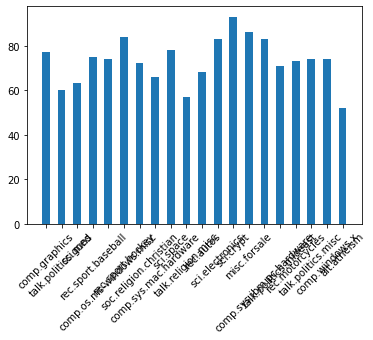

In [63]:
#Category Distribution
counter = Counter(dataset['title'])
topic_names = counter.keys()
topic_counts = counter.values()
ax = plt.gca()
plt.draw()

# Plot histogram using matplotlib bar().
indexes = np.arange(len(topic_names))
width = 0.5
plt.bar(indexes, topic_counts, width)

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.xticks(indexes, topic_names)
plt.show()

In [64]:
print(counter)

Counter({'sci.crypt': 93, 'misc.forsale': 86, 'rec.sport.hockey': 84, 'sci.electronics': 83, 'comp.sys.ibm.pc.hardware': 83, 'sci.space': 78, 'comp.graphics': 77, 'rec.sport.baseball': 75, 'comp.os.ms-windows.misc': 74, 'talk.politics.misc': 74, 'comp.windows.x': 74, 'rec.motorcycles': 73, 'soc.religion.christian': 72, 'talk.politics.mideast': 71, 'rec.autos': 68, 'comp.sys.mac.hardware': 66, 'sci.med': 63, 'talk.politics.guns': 60, 'talk.religion.misc': 57, 'alt.atheism': 52})


## Pre-process data

Lemmatization to get base words

In [65]:
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
  nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
  texts_out = []
  for text in texts:
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [66]:
dataset['news_lemma_text']=lemmatization(dataset['text'])


In [67]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_lemma_text
1,5384,I would like a reference to an algorithm that ...,1,comp.graphics,would like reference algorithm can detect clos...
2,10443,\n\nHere at Lewis and Clark College we have re...,1,comp.graphics,here recently instal system base non - linear ...
3,6305,\nI went back and looked at the review again. ...,1,comp.graphics,go back look review again claim significant di...
4,6583,"\n-> According to the TIFF 5.0 Specification, ...",1,comp.graphics,accord version number choose deep philosophica...
5,7849,re: majority of users not readding from floppy...,1,comp.graphics,majority user readde how cd rom would like use...
6,1156,Hi Everyone--\n\n It's spend-the-money-before...,1,comp.graphics,spend money go time here need find pc base sof...
7,1012,\nI agree with you. Of cause I'll try to be a ...,1,comp.graphics,agree will try daemon
8,10849,"Is the "".3ds"" file format for Autodesk's 3D An...",1,comp.graphics,file format 3d available
9,9656,\nSome VESA bios's support this mode (0x100). ...,1,comp.graphics,bio support mode vga should able support color...
10,3696,I have posted a DOS MPEG decoder/player to alt...,1,comp.graphics,post mpeg decoder player here short descriptio...


Remove Stopword

In [68]:
stop_words = stopwords.words('english')
print(len(stop_words))
stop_words.extend(['from', 'subject', 're', 'edu', 'use','cdw','would','line','article'])
print(len(stop_words))

179
188


In [69]:
#tokenize
def gen_words(texts):
  final = []

  for text in texts:
    new = gensim.utils.simple_preprocess(text, deacc=True)
    for w in new:
      if w in stop_words or len(w)<3:
        new.remove(w)
    final.append(new)
  return (final)
dataset['news_tokens']=gen_words(dataset['news_lemma_text'])

In [70]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens
1,5384,I would like a reference to an algorithm that ...,1,comp.graphics,would like reference algorithm can detect clos...,"[like, reference, algorithm, detect, closed, c..."
2,10443,\n\nHere at Lewis and Clark College we have re...,1,comp.graphics,here recently instal system base non - linear ...,"[recently, instal, system, base, non, linear, ..."
3,6305,\nI went back and looked at the review again. ...,1,comp.graphics,go back look review again claim significant di...,"[back, look, review, claim, significant, diffe..."
4,6583,"\n-> According to the TIFF 5.0 Specification, ...",1,comp.graphics,accord version number choose deep philosophica...,"[accord, version, number, choose, deep, philos..."
5,7849,re: majority of users not readding from floppy...,1,comp.graphics,majority user readde how cd rom would like use...,"[majority, user, readde, cd, rom, like, fast, ..."
6,1156,Hi Everyone--\n\n It's spend-the-money-before...,1,comp.graphics,spend money go time here need find pc base sof...,"[spend, money, time, need, find, base, softwar..."
7,1012,\nI agree with you. Of cause I'll try to be a ...,1,comp.graphics,agree will try daemon,"[agree, try, daemon]"
8,10849,"Is the "".3ds"" file format for Autodesk's 3D An...",1,comp.graphics,file format 3d available,"[file, format, available]"
9,9656,\nSome VESA bios's support this mode (0x100). ...,1,comp.graphics,bio support mode vga should able support color...,"[bio, support, mode, vga, able, support, color..."
10,3696,I have posted a DOS MPEG decoder/player to alt...,1,comp.graphics,post mpeg decoder player here short descriptio...,"[post, mpeg, decoder, player, short, descripti..."


In [71]:
def joinTokens(texts):
  texts_out = []
  for text in texts:
    new_text = []
    for token in text:
            new_text.append(token)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)

In [72]:
dataset['news_joined_text']=joinTokens(dataset['news_tokens'])

In [73]:
dataset.head(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text
1,5384,I would like a reference to an algorithm that ...,1,comp.graphics,would like reference algorithm can detect clos...,"[like, reference, algorithm, detect, closed, c...",like reference algorithm detect closed curve b...
2,10443,\n\nHere at Lewis and Clark College we have re...,1,comp.graphics,here recently instal system base non - linear ...,"[recently, instal, system, base, non, linear, ...",recently instal system base non linear full di...
3,6305,\nI went back and looked at the review again. ...,1,comp.graphics,go back look review again claim significant di...,"[back, look, review, claim, significant, diffe...",back look review claim significant difference ...
4,6583,"\n-> According to the TIFF 5.0 Specification, ...",1,comp.graphics,accord version number choose deep philosophica...,"[accord, version, number, choose, deep, philos...",accord version number choose deep philosophica...
5,7849,re: majority of users not readding from floppy...,1,comp.graphics,majority user readde how cd rom would like use...,"[majority, user, readde, cd, rom, like, fast, ...",majority user readde cd rom like fast work wel...
6,1156,Hi Everyone--\n\n It's spend-the-money-before...,1,comp.graphics,spend money go time here need find pc base sof...,"[spend, money, time, need, find, base, softwar...",spend money time need find base software conto...
7,1012,\nI agree with you. Of cause I'll try to be a ...,1,comp.graphics,agree will try daemon,"[agree, try, daemon]",agree try daemon
8,10849,"Is the "".3ds"" file format for Autodesk's 3D An...",1,comp.graphics,file format 3d available,"[file, format, available]",file format available
9,9656,\nSome VESA bios's support this mode (0x100). ...,1,comp.graphics,bio support mode vga should able support color...,"[bio, support, mode, vga, able, support, color...",bio support mode vga able support color requir...
10,3696,I have posted a DOS MPEG decoder/player to alt...,1,comp.graphics,post mpeg decoder player here short descriptio...,"[post, mpeg, decoder, player, short, descripti...",post mpeg decoder player short description tec...


## Term-document matrix

In [74]:
vect =TfidfVectorizer(stop_words=stop_words,max_features=1000)

In [75]:
vect_text=vect.fit_transform(dataset['news_joined_text'])

In [76]:
print(vect_text)

  (0, 908)	0.28949595438995107
  (0, 166)	0.4359812133525767
  (0, 490)	0.4172743278024563
  (0, 594)	0.3115847387464016
  (0, 27)	0.4421353163611702
  (0, 734)	0.4148955437909331
  (0, 493)	0.2954447659063283
  (1, 89)	0.06569101982055812
  (1, 420)	0.07176951993825627
  (1, 635)	0.0691120864293959
  (1, 294)	0.041512606125460136
  (1, 147)	0.07580929958913729
  (1, 618)	0.07011554996157862
  (1, 72)	0.0472063557530188
  (1, 809)	0.05104408135073805
  (1, 561)	0.06531653057634136
  (1, 259)	0.052900105380577475
  (1, 927)	0.06772974028737526
  (1, 445)	0.07364463644475587
  (1, 951)	0.06203599065981658
  (1, 729)	0.07505005985478105
  (1, 793)	0.03836554849173868
  (1, 296)	0.056342241032257906
  (1, 267)	0.059378557150956204
  (1, 319)	0.06531653057634136
  :	:
  (1462, 886)	0.09646744688902942
  (1462, 125)	0.12725178886943506
  (1462, 457)	0.09721079697492054
  (1462, 860)	0.10246616631085197
  (1462, 621)	0.13325050829125765
  (1462, 610)	0.1127620634967007
  (1462, 427)	0.0919765

## Single Value Decompostion


In [77]:
from sklearn.decomposition import TruncatedSVD
lsa_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10, random_state=42)

## Topic Encoded Data

In [78]:
lsa_top=lsa_model.fit_transform(vect_text)


Words Associated with the topic

In [79]:
vocab = vect.get_feature_names()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")
         

Topic 0: 
know think say people make may see good get could 

Topic 1: 
file thank card drive mail need driver disk system advance 

Topic 2: 
team game year player season play win last drive good 

Topic 3: 
thank mail post advance know address list team look email 

Topic 4: 
key file chip encryption team government game system run player 

Topic 5: 
file say problem run drive image window try write happen 

Topic 6: 
card driver thank chip know key system problem video monitor 

Topic 7: 
drive hard chip make disk say file card thank people 

Topic 8: 
know car chip key bike file let buy want need 

Topic 9: 
think post drive may problem want list mail could key 

Topic 10: 
make look problem work email post drive also offer hard 

Topic 11: 
think make look need buy still even offer build team 

Topic 12: 
look card post good car player system monitor know color 

Topic 13: 
know may need let want offer include shipping sale sell 

Topic 14: 
year think problem government mail file

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [80]:
twords={}
for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    arr = []
    for t in sorted_words:
       arr.append(t[0])
    twords[i]=arr
print(twords)


{0: ['know', 'think', 'say', 'people', 'make', 'may', 'see', 'good', 'get', 'could'], 1: ['file', 'thank', 'card', 'drive', 'mail', 'need', 'driver', 'disk', 'system', 'advance'], 2: ['team', 'game', 'year', 'player', 'season', 'play', 'win', 'last', 'drive', 'good'], 3: ['thank', 'mail', 'post', 'advance', 'know', 'address', 'list', 'team', 'look', 'email'], 4: ['key', 'file', 'chip', 'encryption', 'team', 'government', 'game', 'system', 'run', 'player'], 5: ['file', 'say', 'problem', 'run', 'drive', 'image', 'window', 'try', 'write', 'happen'], 6: ['card', 'driver', 'thank', 'chip', 'know', 'key', 'system', 'problem', 'video', 'monitor'], 7: ['drive', 'hard', 'chip', 'make', 'disk', 'say', 'file', 'card', 'thank', 'people'], 8: ['know', 'car', 'chip', 'key', 'bike', 'file', 'let', 'buy', 'want', 'need'], 9: ['think', 'post', 'drive', 'may', 'problem', 'want', 'list', 'mail', 'could', 'key'], 10: ['make', 'look', 'problem', 'work', 'email', 'post', 'drive', 'also', 'offer', 'hard'], 1

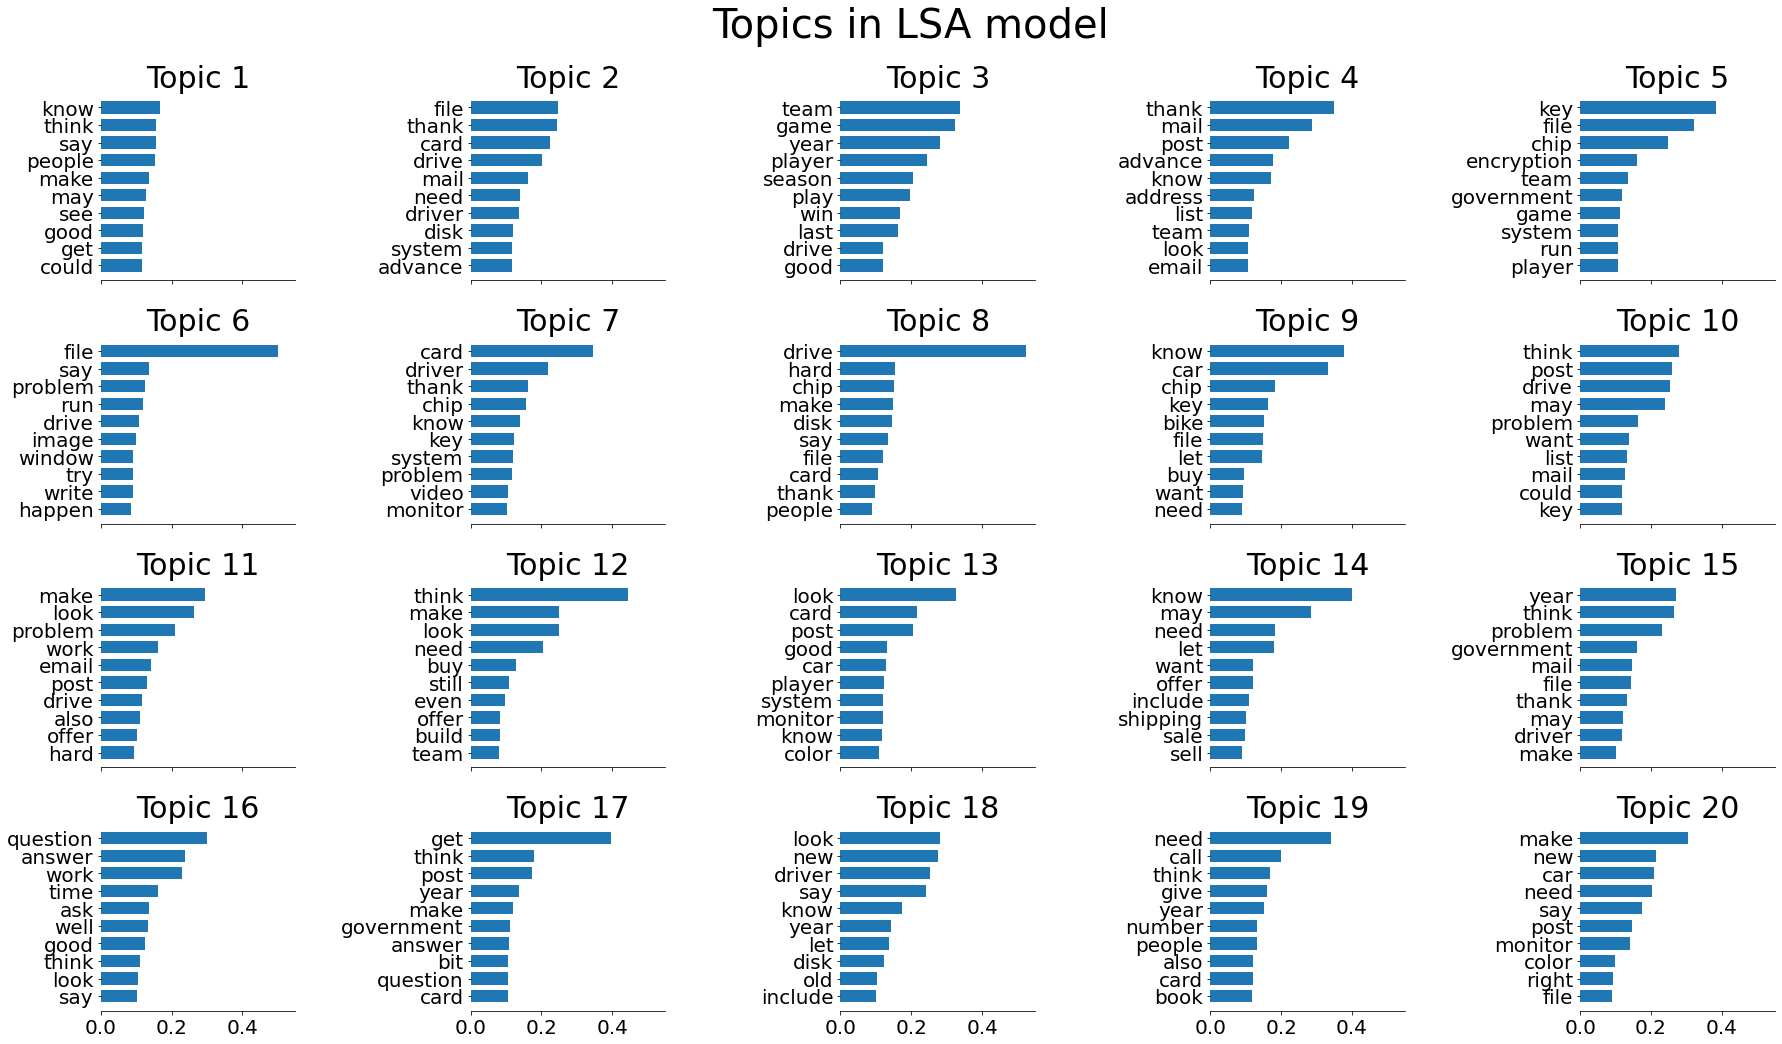

In [81]:
n_components = 20
n_top_words = 10


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

tfidf_feature_names = vect.get_feature_names_out()
plot_top_words(lsa_model, tfidf_feature_names, n_top_words, "Topics in LSA model")

Best Topic

In [82]:
# print scores
l=lsa_top[0]
print("Document", 0," :")
for i,topic in enumerate(l):
    print("Topic ",i," : ",topic*100)
  
  

Document 0  :
Topic  0  :  8.98847900059481
Topic  1  :  10.060935883601777
Topic  2  :  -3.230440409810995
Topic  3  :  15.173383288486662
Topic  4  :  -0.3014664552677568
Topic  5  :  -8.34076399441769
Topic  6  :  4.604989954563705
Topic  7  :  2.6747638564467957
Topic  8  :  1.596665156339946
Topic  9  :  -2.742613257902053
Topic  10  :  0.7005655132368257
Topic  11  :  1.5121687186566888
Topic  12  :  -5.871449900821036
Topic  13  :  -2.6798672222081725
Topic  14  :  2.4664054213754985
Topic  15  :  -0.35837904329843306
Topic  16  :  -8.244416438014094
Topic  17  :  -2.657920315631445
Topic  18  :  1.7006207123701482
Topic  19  :  -4.450085854161681


In [83]:
def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return(sub_li)

def best_topic():
 arr =[]
 topicWords =[]
 num =0
 for x in range(0, dataset['text'].size):
    l=lsa_top[x]
    val=[]
   # print("Document", num," :")
    for i,topic in enumerate(l):
      #print("Topic ",i," : ",topic*100)
      val.append(topic)
      
    num = num +1
    topicWords.append(twords.get(np.argmax(val)))
    arr.append(np.argmax(val))
 dataset['best_topic_lsa']=arr
 dataset['best_topic_lsa_words']=topicWords

best_topic()

In [84]:
dataset.sample(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text,best_topic_lsa,best_topic_lsa_words
628,10219,\n: >There is an emergency oxygen system that ...,14,sci.space,emergency oxygen system capable maintain breat...,"[emergency, oxygen, system, capable, maintain,...",emergency oxygen system capable maintain breat...,0,"[know, think, say, people, make, may, see, goo..."
388,3700,\n\n\nI have one complaint for the cameramen d...,10,rec.sport.hockey,complaint cameraman do series shot hit more oc...,"[complaint, cameraman, series, shot, hit, occa...",complaint cameraman series shot hit occassion ...,0,"[know, think, say, people, make, may, see, goo..."
562,2657,When is Apple supposed to start bundlign the n...,4,comp.sys.mac.hardware,when suppose start bundlign new ergonomic cpu ...,"[suppose, start, bundlign, new, ergonomic, cpu...",suppose start bundlign new ergonomic cpu sell,17,"[look, new, driver, say, know, year, let, disk..."
168,1470,"\nHate to wreck your elaborate theory, but Ste...",13,sci.med,hate wreck elaborate theory so professional je...,"[hate, wreck, elaborate, theory, professional,...",hate wreck elaborate theory professional jealo...,0,"[know, think, say, people, make, may, see, goo..."
103,8128,Bill Vojak:\n\n BV>I read in the paper yestard...,16,talk.politics.guns,read paper yestarday want trim down medium hol...,"[read, paper, yestarday, want, trim, medium, h...",read paper yestarday want trim medium holding ...,0,"[know, think, say, people, make, may, see, goo..."
1392,4639,"Enclosed are the rules, guidelines and related...",5,comp.windows.x,enclose rule guideline related information 10t...,"[enclose, rule, guideline, related, informatio...",enclose rule guideline related information par...,0,"[know, think, say, people, make, may, see, goo..."
140,10846,NUT CASE PANICS!!!!REALIZES HE'S MADE A COMPLE...,16,talk.politics.guns,panics!!!!realizes make complete fool front th...,"[panics, realizes, make, complete, fool, front...",panics realizes make complete fool front thous...,19,"[make, new, car, need, say, post, monitor, col..."
1146,4370,\nSince the Mac uses ONLY SCSI-1 for hard driv...,3,comp.sys.ibm.pc.hardware,use only scsi-1 hard drive figure include driv...,"[only, scsi, hard, drive, figure, include, dri...",only scsi hard drive figure include driver slo...,1,"[file, thank, card, drive, mail, need, driver,..."
1077,1043,How can one tell which prong of your basic chi...,3,comp.sys.ibm.pc.hardware,how can tell prong basic chip number realize t...,"[tell, prong, basic, chip, number, realize, ch...",tell prong basic chip number realize chunk chi...,4,"[key, file, chip, encryption, team, government..."
582,10691,"Peter, I'm sure someone out there has a better...",4,comp.sys.mac.hardware,sure out well easy way want will tell how wher...,"[sure, well, easy, way, want, tell, where, wor...",sure well easy way want tell where work networ...,0,"[know, think, say, people, make, may, see, goo..."


## Cosine Similarity

In [85]:
# get original topic words
dataset['target_topic_word']= dataset['title'].str.split('.')
dataset.sample(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,news_joined_text,best_topic_lsa,best_topic_lsa_words,target_topic_word
682,7612,"\n\tSo, if I were to assert that there are no ...",19,talk.religion.misc,so assert year old invisible pink unicorn resi...,"[assert, year, old, invisible, pink, unicorn, ...",assert year old invisible pink unicorn reside ...,0,"[know, think, say, people, make, may, see, goo...","[talk, religion, misc]"
593,10422,\nA freeze dried Tootsie Roll (tm). The actua...,14,sci.space,freeze dry tm actual taste sensation will ever...,"[freeze, dry, actual, taste, sensation, ever, ...",freeze dry actual taste sensation ever willing...,0,"[know, think, say, people, make, may, see, goo...","[sci, space]"
151,4215,Does anybody know of any information regarding...,13,sci.med,know information regard implementaion total qu...,"[know, information, regard, implementaion, tot...",know information regard implementaion total qu...,3,"[thank, mail, post, advance, know, address, li...","[sci, med]"
991,7762,"Hi,\n\nSince the original buyer found out he c...",6,misc.forsale,original buyer find could use modem beleive me...,"[original, buyer, find, could, modem, beleive,...",original buyer find could modem beleive mentio...,3,"[thank, mail, post, advance, know, address, li...","[misc, forsale]"
1242,11094,"3500 miles, black leather tank bra, tank bag, ...",8,rec.motorcycles,mile black leather tank bra tank bag seat tire...,"[mile, black, leather, tank, bra, tank, bag, s...",mile black leather tank bra tank bag seat tire...,18,"[need, call, think, give, year, number, people...","[rec, motorcycles]"
607,10679,GS> How about transferring control to a non-pr...,14,sci.space,how transfer control non - profit organisation...,"[transfer, control, non, profit, organisation,...",transfer control non profit organisation able ...,0,"[know, think, say, people, make, may, see, goo...","[sci, space]"
301,978,Has anyone had experience with the new Greenle...,2,comp.os.ms-windows.misc,experience new can even demo winterm run baud ...,"[experience, new, even, demo, winterm, run, ba...",experience new even demo winterm run baud drop...,0,"[know, think, say, people, make, may, see, goo...","[comp, os, ms-windows, misc]"
392,9802,On 20-Apr-93 in Don Cherry - Coach's Corner..\...,10,rec.sport.hockey,clip show local news last night complete anima...,"[clip, show, local, news, last, night, complet...",clip show local news last night complete anima...,0,"[know, think, say, people, make, may, see, goo...","[rec, sport, hockey]"
423,11046,-=> Quoting Cire Y. Trehguad to All <=-\n : >A...,10,rec.sport.hockey,subject captain ever trade resign stripe title...,"[captain, ever, trade, resign, stripe, title, ...",captain ever trade resign stripe title season ...,2,"[team, game, year, player, season, play, win, ...","[rec, sport, hockey]"
50,7326,My CorelDRAW 3.0.whatever write SCODL files di...,1,comp.graphics,write file directly look file|export main menu,"[write, file, directly, look, file, export, ma...",write file directly look file export main menu,5,"[file, say, problem, run, drive, image, window...","[comp, graphics]"


In [86]:
#cosine similarity
from collections import Counter

def cosine_similarity(x,num):
   a_vals = Counter(x)
   b_vals = Counter(y)
   words = list(set(a_vals) | set(b_vals))
   # convert to word-vectors
   a_vect = [a_vals.get(s, 0) for s in words]
   b_vect = [b_vals.get(s, 0) for s in words] 

  # find cosine
   len_a  = sum(av*av for av in a_vect) ** 0.5 
   len_b  = sum(bv*bv for bv in b_vect) ** 0.5   
   dot = sum(av*bv for av,bv in zip(a_vect, b_vect)) 
   if len_a == 0 or len_b == 0 :
    cosine = 1
   else:
    cosine = dot / (len_a * len_b)     
   return cosine

arr =[]
num =0
for x in dataset['best_topic_lsa_words']:
  y = dataset['target_topic_word'].values[num]
  # print(y)
  arr.append(cosine_similarity(x,y))
  num = num +1

print(arr)
print("The average cosine similarity is:", np.mean(arr))


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,